## Label flip prediction analysis

These experiments are meant to be a simple control: we're taking samples that we know have a positive label (i.e. have a mutation in the gene of interest), then we flip these to negative and evaluate how well we can predict them.

If this doesn't work well within cancer types, we're probably wasting our time looking at prediction across genes and across cancer types.

In [15]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [16]:
results_dir = os.path.join(cfg.repo_root,
                           'cross_cancer_flip_remove',
                           'cross_cancer_flip_labels')
flip_labels_df = (
    au.load_flip_labels_results(results_dir, 'flip_labels')
      .sort_values(by=['train_identifier', 'test_identifier',
                       'percent_flip', 'signal'])
)
print(flip_labels_df.shape)
flip_labels_df.head(n=10)

(1050, 9)


,auroc,aupr,train_identifier,test_identifier,signal,seed,data_type,percent_flip,experiment
0,0.93951,0.592760,BRAF_COAD,BRAF_COAD,shuffled,42,train,0.1,flip_labels
1,0.37500,0.008978,BRAF_COAD,BRAF_COAD,shuffled,42,test,0.1,flip_labels
2,0.47181,0.073147,BRAF_COAD,BRAF_COAD,shuffled,42,cv,0.1,flip_labels
0,0.99362,0.924860,BRAF_COAD,BRAF_COAD,signal,42,train,0.1,flip_labels
1,0.98507,0.600000,BRAF_COAD,BRAF_COAD,signal,42,test,0.1,flip_labels
2,0.67531,0.146030,BRAF_COAD,BRAF_COAD,signal,42,cv,0.1,flip_labels
0,1.00000,1.000000,BRAF_COAD,BRAF_COAD,shuffled,42,train,0.2,flip_labels
1,0.53451,0.026240,BRAF_COAD,BRAF_COAD,shuffled,42,test,0.2,flip_labels
2,0.44256,0.059475,BRAF_COAD,BRAF_COAD,shuffled,42,cv,0.2,flip_labels
0,1.00000,1.000000,BRAF_COAD,BRAF_COAD,signal,42,train,0.2,flip_labels


In [17]:
flip_norm_df = au.normalize_to_control(flip_labels_df,
                                       train_id='train_identifier',
                                       test_id='test_identifier',
                                       additional_cols=['percent_flip'])
flip_norm_df = (
    flip_norm_df.assign(gene=lambda x: x.train_identifier.str.split('_', expand=True)[0],
                        cancer_type=lambda x: x.train_identifier.str.split('_', expand=True)[1])
                .drop(columns=['train_identifier', 'test_identifier'])
                .reset_index()
)
flip_norm_df.head()

,index,percent_flip,aupr,gene,cancer_type
0,1,0.1,0.591023,BRAF,COAD
1,1,0.2,0.031522,BRAF,COAD
2,1,0.3,0.192914,BRAF,COAD
3,1,0.5,-0.019665,BRAF,COAD
4,1,0.1,0.006582,BRAF,LUAD


In [40]:
sns.set({'figure.figsize': (15, 10)})
fig, axarr = plt.subplots(2, 2)

percents_flip = flip_norm_df.percent_flip.unique()
for ix, percent_flip in enumerate(percents_flip):
    ax = axarr[ix // 2, ix % 2] 
    heatmap_df = (
        flip_norm_df.query('percent_flip == @percent_flip')
                    .pivot(index='gene', columns='cancer_type', values='aupr')
    )
    sns.heatmap(heatmap_df, vmin=0.0, vmax=1.0, ax=ax)
    ax.set_title('Percent of labels flipped: {}'.format(percent_flip))
plt.tight_layout()

The above heatmap shows predictive performance for varying percentage of true positives flipped to negative (10%, 20%, 30%, 50%) and for several genes/cancer types. Takeaways:

1. Performance looks fairly good for many genes and cancer types (TP53, KRAS, BRAF most of the time) but not so good for others (PTEN)
2. Performance is fairly stable across percentages of labels flipped, which indicates that this evaluation scheme makes sense (past attempts weren't at all consistent/stable).

In [19]:
flip_norm_df['identifier'] = flip_norm_df.gene + '_' + flip_norm_df.cancer_type
flip_norm_df.head()

,index,percent_flip,aupr,gene,cancer_type,identifier
0,1,0.1,0.591023,BRAF,COAD,BRAF_COAD
1,1,0.2,0.031522,BRAF,COAD,BRAF_COAD
2,1,0.3,0.192914,BRAF,COAD,BRAF_COAD
3,1,0.5,-0.019665,BRAF,COAD,BRAF_COAD
4,1,0.1,0.006582,BRAF,LUAD,BRAF_LUAD


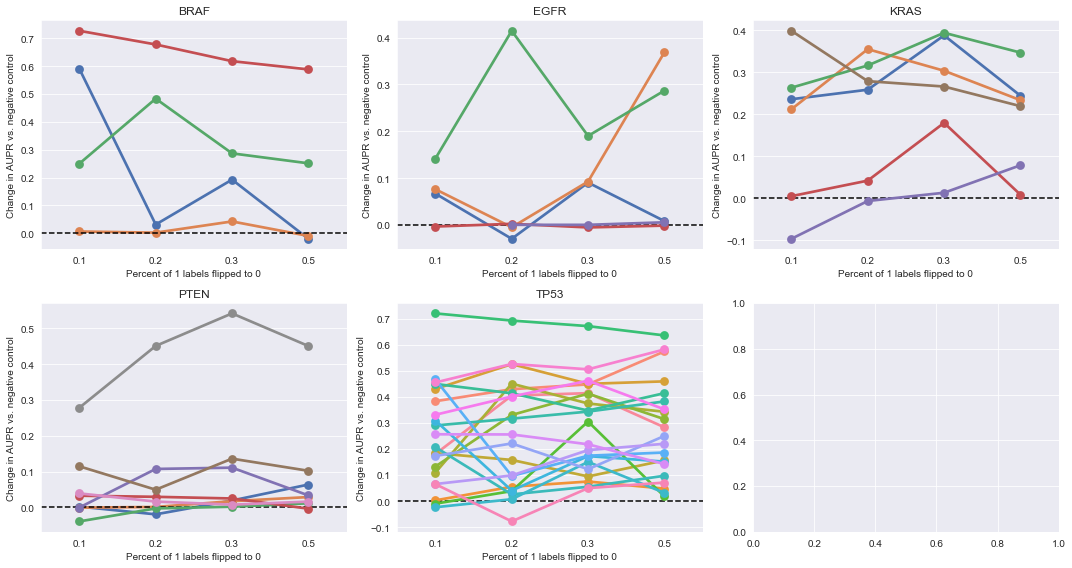

In [30]:
plot_genes = flip_norm_df.gene.unique()
sns.set({'figure.figsize': (15, 8)})
fig, axarr = plt.subplots(2, 3)
for ix, plot_gene in enumerate(plot_genes):
    ax = axarr[ix // 3, ix % 3] 
    plot_df = flip_norm_df[flip_norm_df.gene == plot_gene]
    sns.pointplot(data=plot_df, x='percent_flip', y='aupr', hue='identifier', ax=ax)
    ax.set_xlabel('Percent of 1 labels flipped to 0')
    ax.set_ylabel('Change in AUPR vs. negative control')
    ax.set_title(plot_gene)
    ax.get_legend().remove()
    ax.axhline(y=0, color='black', linestyle='--')
plt.tight_layout()
# is there a way to show info about cancer types?

The line plots above are just another way to visualize trends as more labels are flipped. Each plot is a gene, each line is a cancer type. There don't seem to be any strong trends here, which is what we want (eventually performance should degrade as we have less training data, so we'll need to look at that in the future, but for now we just want to see robustness and most lines above 0, which we do see).